In [1]:
# Load the packages
import math
import matplotlib.pyplot as plt
import seaborn as sns
import shap as shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

# Libraries for missing values:
import missingno as msno   
# !pip install fancyimpute --target=/kaggle/working/
#import fancyimpute
warnings.filterwarnings("ignore")





In [79]:
# 2. Create interactive widgets in Jupyter notebooks
# Use Jupyter Widges Package - https://ipywidgets.readthedocs.io/en/stable/index.html 
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
style = {'description_width': 'initial'}

# Configure pandas
pd.set_option('display.max_colwidth', None) # do not truncate column values
pd.set_option('display.max_rows', 200)      # max number of rows to display 
pd.set_option('display.max_columns', 300)   # max number of columns to display 

In [140]:
# Load the data
df_train = pd.read_csv("../datasets/train_new.csv", index_col='id')
df_test = pd.read_csv("../datasets/test_new.csv", index_col='id')

# get a list of categorical and numerical variables
categorical_features = list(df_train.select_dtypes(include=['object', 'category']).columns)
numerical_features = list(df_train.select_dtypes(include=['float64', 'int64']).columns)[:-1]

target_feature = 'price'

df_train.head()


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000,1,Ford,375.0,3.5,6.0,10.0,Automatic,blue,grey
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,8250,3,BMW,300.0,3.0,6.0,6.0,Manual,black,black
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000,3,other,300.0,4.2,8.0,6.0,Automatic,others,brown
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500,3,BMW,335.0,3.0,6.0,NaN,AM,grey,brown
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850,1,other,200.0,3.8,6.0,NaN,Automatic,white,black


In [133]:
# print out the size of the data set
print("Shape of training set: ", df_train.shape)
print("Shape of testing set:", df_test.shape)

Shape of training set:  (54273, 21)
Shape of testing set: (36183, 20)


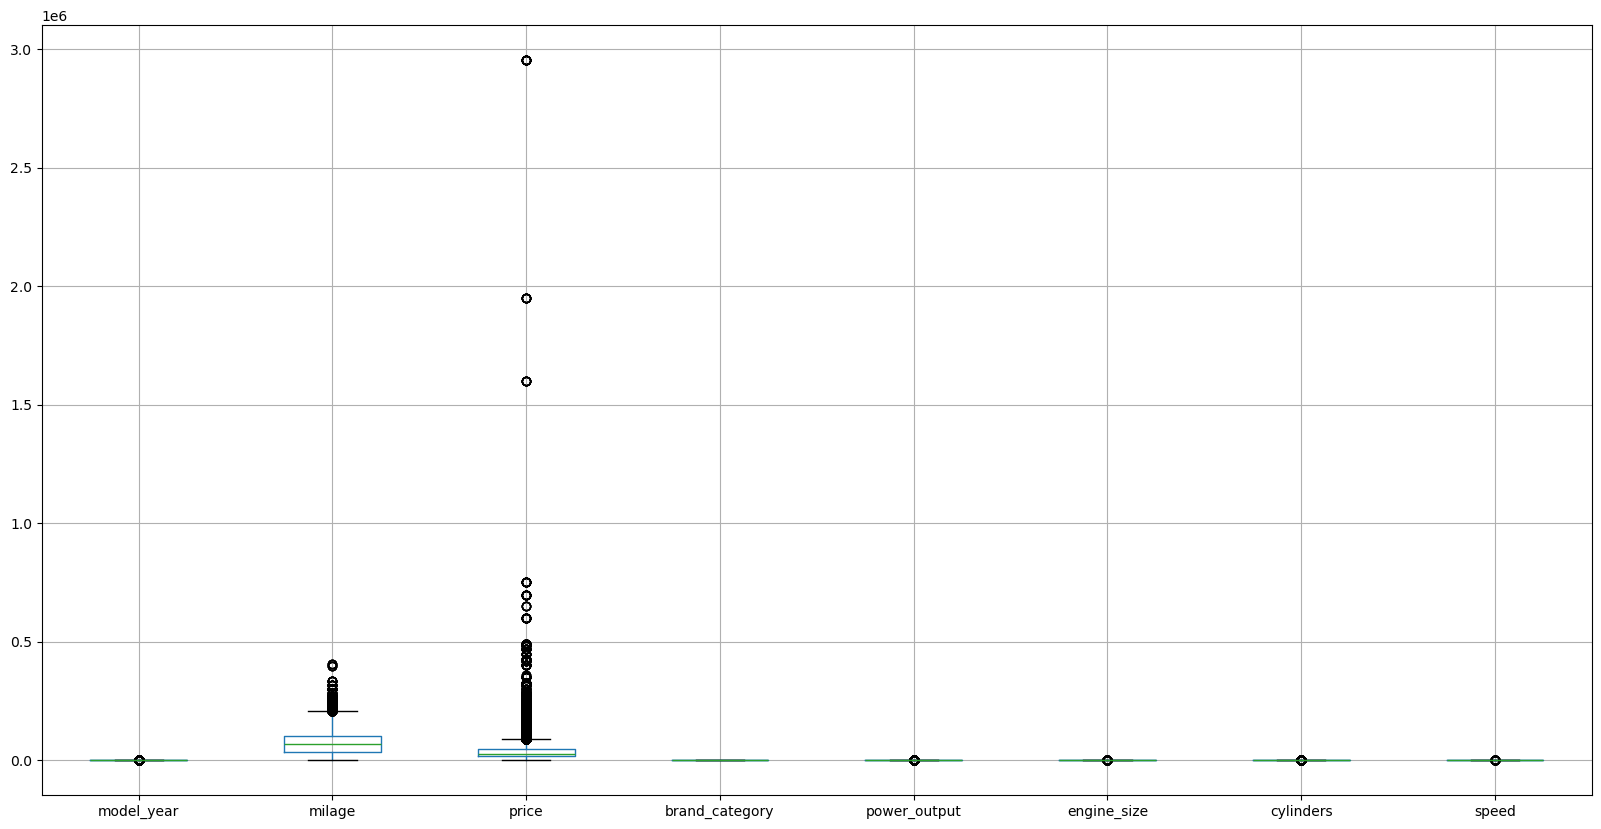

In [134]:
# identify outliers
df_train.boxplot(figsize=(20, 10))
plt.show()

In [141]:
# Exclude outliers using iqr/z-score 
#df_train = df_train[~((df_train['price'] > 200000) & (df_train['brand_category'] == 1))]

from scipy.stats import zscore

# Define a function to calculate IQR and filter outliers
def remove_outliers_iqr(group):
    Q1 = group['price'].quantile(0.25)
    Q3 = group['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['price'] >= lower_bound) & (group['price'] <= upper_bound)]

'''
# Define a function to calculate Z-scores and filter outliers
def remove_outliers(group):
    group['z_score'] = zscore(group['price'])
    return group[np.abs(group['z_score']) <= 3]
'''

# Apply the function to each group of brand and model
#filtered_df = 
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_train = df_train.groupby(['brand', 'model']).apply(remove_outliers_iqr).reset_index(drop=True)

# Drop the z_score column as it's no longer needed
#df_train = df_train.drop(columns=['z_score'])

#df_train.set_index('id', inplace=True)

df_train.head()


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
0,27209,Acura,BRZ Limited,2013,70582,Gasoline,200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed M/T,White,Black,None reported,Yes,17900,2,other,200.0,2.0,4.0,6.0,Manual,white,black
1,11434,Acura,Boxster S,2020,25000,Gasoline,280.0HP 3.2L Flat 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,White,Gray,None reported,Yes,35999,2,other,280.0,3.2,6.0,6.0,Manual,white,grey
2,12270,Acura,Celica GT,2001,122000,Gasoline,140.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,5-Speed M/T,Blue,–,None reported,Yes,7800,2,other,140.0,1.8,4.0,5.0,Manual,blue,others
3,22959,Acura,ES 350 Base,2007,78980,Gasoline,272.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Silver,Beige,At least 1 accident or damage reported,Yes,10600,2,other,272.0,3.5,6.0,6.0,Manual,silver,brown
4,23411,Acura,Elantra SE,2010,153843,Gasoline,150.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,5-Speed M/T,Red,Beige,At least 1 accident or damage reported,Yes,9450,2,other,150.0,2.0,4.0,5.0,Manual,red,brown


In [145]:
# print out the size of the data set
print("Shape of training set: ", df_train.shape)
print("Shape of testing set:", df_test.shape)

Shape of training set:  (51122, 22)
Shape of testing set: (36183, 21)


While the z-score reduced the number of outliers we still saw outliers in prices where regular cars like Toyota which are supposed to be priced arounf 30K-40K recorded at 115K. 

In [8]:
# review cars over 100K not in luxury category
df_train[(df_train['price']> 100000) & 
         (df_train['brand_category']== 1)  ]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,,,,,,,,
17669,Chevrolet,Capri XR2,1996,167000,Unknown,–,4-Speed A/T,White,Gray,None reported,Yes,220000,1,Chevrolet,NaN,NaN,NaN,4.0,Automatic,white,grey
4221,Chevrolet,Corvette Stingray w/1LT,2023,8400,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,104000,1,Chevrolet,490.0,6.20,8.0,NaN,Automatic,black,black
5736,Chevrolet,Corvette Stingray w/1LT,2022,9000,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Black,None reported,Yes,130000,1,Chevrolet,490.0,6.20,8.0,NaN,Automatic,others,black
8986,Chevrolet,Corvette Stingray w/1LT,2023,3053,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Red,None reported,Yes,123999,1,Chevrolet,490.0,6.20,8.0,8.0,Automatic,white,red
10950,Chevrolet,Corvette Stingray w/1LT,2022,17900,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,White,None reported,Yes,104000,1,Chevrolet,490.0,6.20,8.0,8.0,Automatic,white,white
19559,Chevrolet,Corvette Stingray w/1LT,2023,7000,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,144900,1,Chevrolet,490.0,6.20,8.0,NaN,Automatic,white,black
27820,Chevrolet,Corvette Stingray w/1LT,2023,4000,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Orange,None reported,Yes,145000,1,Chevrolet,490.0,6.20,8.0,NaN,AM,black,others
33143,Chevrolet,Corvette Stingray w/1LT,2022,11806,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Red,None reported,Yes,112500,1,Chevrolet,490.0,6.20,8.0,8.0,Automatic,white,red
35289,Chevrolet,Corvette Stingray w/1LT,2023,9000,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Gray,Black,None reported,Yes,110000,1,Chevrolet,490.0,6.20,8.0,NaN,AM,grey,black


In [9]:
df_train[(df_train['brand'] == "Toyota") & 
         (df_train['model']== "Tundra Platinum")  ]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,,,,,,,,
3847,Toyota,Tundra Platinum,2022,8800,Gasoline,389.0HP 3.4L V6 Cylinder Engine Gasoline Fuel,A/T,Green,Brown,None reported,Yes,68500,1,Toyota,389.0,3.4,6.0,NaN,Automatic,others,brown
3983,Toyota,Tundra Platinum,2019,34672,Gasoline,389.0HP 3.4L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Black,None reported,Yes,45999,1,Toyota,389.0,3.4,6.0,10.0,Automatic,blue,black
7214,Toyota,Tundra Platinum,2018,53750,Gasoline,389.0HP 3.4L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Black,None reported,Yes,39650,1,Toyota,389.0,3.4,6.0,10.0,Automatic,blue,black
8365,Toyota,Tundra Platinum,2018,66000,E85 Flex Fuel,381.0HP 5.7L 8 Cylinder Engine Flex Fuel Capability,6-Speed A/T,Gray,Black,None reported,Yes,49900,1,Toyota,381.0,5.7,8.0,6.0,Automatic,grey,black
8524,Toyota,Tundra Platinum,2018,66000,Gasoline,381.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Gray,Black,None reported,Yes,65000,1,Toyota,381.0,5.7,8.0,6.0,Automatic,grey,black
14258,Toyota,Tundra Platinum,2018,66000,Gasoline,381.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,52000,1,Toyota,381.0,5.7,8.0,NaN,Automatic,white,black
21952,Toyota,Tundra Platinum,2020,6600,Gasoline,381.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,75500,1,Toyota,381.0,5.7,8.0,NaN,Automatic,white,black
24305,Toyota,Tundra Platinum,2018,67865,Gasoline,389.0HP 3.4L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,At least 1 accident or damage reported,Yes,42500,1,Toyota,389.0,3.4,6.0,NaN,Automatic,white,black
25282,Toyota,Tundra Platinum,2023,15500,Gasoline,389.0HP 3.4L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,65000,1,Toyota,389.0,3.4,6.0,NaN,Automatic,blue,black


In [122]:
# summary statistics of numeric features
# price = target feature
df_train.describe()

,model_year,milage,price,brand_category,power_output,engine_size,cylinders,speed
count,51122.000000,51122.000000,5.112200e+04,51122.000000,47409.000000,50557.000000,47297.000000,27579.000000
mean,2015.005790,74003.944095,3.314744e+04,1.984801,331.244953,3.716209,6.282195,7.088654
std,5.571669,50281.091609,3.348470e+04,0.945030,107.898713,1.333093,1.538677,1.501108
min,1974.000000,100.000000,2.000000e+03,1.000000,76.000000,0.650000,3.000000,1.000000
25%,2012.000000,34672.000000,1.500000e+04,1.000000,255.000000,3.000000,6.000000,6.000000
50%,2016.000000,67500.000000,2.699000e+04,2.000000,310.000000,3.500000,6.000000,7.000000
75%,2019.000000,103400.000000,4.270000e+04,3.000000,400.000000,4.600000,8.000000,8.000000
max,2024.000000,405000.000000,2.954083e+06,3.000000,1020.000000,8.400000,12.000000,10.000000


In [96]:
# model: too many unique values @ 1827
# engine: too many unique values -> can be broken down with NLP 
# transmission: can be broken down with NLP
# ext_col and int_col: too many values?

# clean_title: redundant feature since only one value present

df_train.describe(include=["object", "bool"])

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,top_brand,transmission_type,ext_color_basic,int_color_basic
count,52722,52722,52722,52722,52722,52722,52722,52722,52722,52722,52722,52722,52722
unique,51,1738,6,1042,44,257,123,2,1,14,5,8,8
top,BMW,F-150 XLT,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,other,Automatic,black,black
freq,7190,767,48068,1424,16286,14663,30912,38662,52722,12005,40991,15302,31776


In [97]:
df_test.describe(include=["object", "bool"])

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,top_brand,transmission_type,ext_color_basic,int_color_basic
count,36183,36183,36183,36183,36183,36183,36183,36183,36183,36183,36183,36183,36183
unique,53,1791,6,1038,44,230,111,2,1,14,5,8,8
top,BMW,F-150 XLT,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,other,Automatic,black,black
freq,4854,496,33033,886,11273,10027,21122,26598,36183,8261,28052,10443,21710


In [98]:
# check for duplicates
num_duplicates = df_train.duplicated().sum()

if num_duplicates !=0:
    print(f'There are {num_duplicates} duplicate rows, removing them from the data.')
    df_train.drop_duplicates(inplace=True)
else:
    print(f'{num_duplicates} duplicate rows detected.')

0 duplicate rows detected.


In [146]:
# check for missing values
def check_missing_values(df):
    missing_columns = [col for col in df.columns if df[col].isnull().any()]
    missingvalues_count =df.isna().sum()
    missingValues_df = pd.DataFrame(missingvalues_count.rename('Missing Values')).loc[missingvalues_count.ne(0)]
    missingValues_df['Percentage'] = missingValues_df['Missing Values'] * 100 / df.shape[0]
    return missingValues_df

df = check_missing_values(df_train)
print(df.sort_values(by='Missing Values', ascending=False))

              Missing Values  Percentage
speed                  23543   46.052580
cylinders               3825    7.482102
power_output            3713    7.263018
engine_size              565    1.105199


In [147]:
# "imputing" missing values based on brand and model grouping

# Combine df_train and df_test to calculate the average speed
combined_df = pd.concat([df_train, df_test])

# Group by 'brand' and 'model' and calculate the average values, ignoring NaN values
grouped_df = combined_df.groupby(['brand', 'model']).agg({
    'speed': 'mean',
    'cylinders': 'mean',
    'power_output': 'mean',
    'engine_size': 'mean'
}).reset_index()

# Define a function to merge and update values for the given columns
def update_columns(df, grouped_df, columns):
    # Merge on ['brand', 'model'] and preserve original index
    df_merged = df.merge(grouped_df, 
                         how='left',
                         #left_index=True, right_index=True,
                         on=['brand', 'model'], suffixes=('', '_mean')  )#.reset_index().set_index('id')

    #df1.merge(df2, how="inner", left_index=True, right_index=True)
    for col in columns:
        df_merged[col] = df_merged.apply(lambda row: row[f'{col}_mean'] if pd.isna(row[col]) else row[col], axis=1)
    return df_merged.drop(columns=[f'{col}_mean' for col in columns])

# List of columns to update
columns_to_update = ['speed', 'cylinders', 'power_output', 'engine_size']

# Update columns in both df_train and df_test
df_train = update_columns(df_train, grouped_df, columns_to_update)
df_test = update_columns(df_test, grouped_df, columns_to_update)

#df_train.set_index('id', inplace=True)

df = check_missing_values(df_train)
print(df.sort_values(by='Missing Values', ascending=False))

              Missing Values  Percentage
speed                    844    1.650953
cylinders                607    1.187356
power_output             436    0.852862
engine_size              211    0.412738


In [148]:
df_train = df_train.set_index('id')#.drop(columns='index', axis=1, inplace=True)
df_test = df_test.set_index('id')#.drop(columns='index', axis=1, inplace=True)
#grouped_df
df_train

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,,,,,,,,
27209,Acura,BRZ Limited,2013,70582,Gasoline,200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed M/T,White,Black,None reported,Yes,17900,2,other,200.0,2.0,4.0,6.000000,Manual,white,black
11434,Acura,Boxster S,2020,25000,Gasoline,280.0HP 3.2L Flat 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,White,Gray,None reported,Yes,35999,2,other,280.0,3.2,6.0,6.000000,Manual,white,grey
12270,Acura,Celica GT,2001,122000,Gasoline,140.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,5-Speed M/T,Blue,–,None reported,Yes,7800,2,other,140.0,1.8,4.0,5.000000,Manual,blue,others
22959,Acura,ES 350 Base,2007,78980,Gasoline,272.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Silver,Beige,At least 1 accident or damage reported,Yes,10600,2,other,272.0,3.5,6.0,6.000000,Manual,silver,brown
23411,Acura,Elantra SE,2010,153843,Gasoline,150.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,5-Speed M/T,Red,Beige,At least 1 accident or damage reported,Yes,9450,2,other,150.0,2.0,4.0,5.000000,Manual,red,brown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51848,Volvo,XC90 T6 Momentum,2018,110380,Gasoline,316.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Beige,At least 1 accident or damage reported,Yes,31000,2,other,316.0,2.0,4.0,8.000000,Automatic,white,brown
52127,Volvo,XC90 T6 Momentum,2018,60660,Gasoline,316.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,None reported,Yes,26000,2,other,316.0,2.0,4.0,8.000000,Automatic,white,black
53219,Volvo,XC90 T6 Momentum,2017,66500,Gasoline,316.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,8-Speed A/T,Silver,Gray,At least 1 accident or damage reported,Yes,22500,2,other,316.0,2.0,4.0,8.000000,Automatic,silver,grey


### Dropping columns 

modified columns: engine, transmission, ext_col, int_col, 

missing values: aspiration, valves, cylinder_layout, 

redundunt: clean_title , 



In [150]:
## drop columns
col_to_drop = [ 'engine', 'transmission', 'ext_col', 'int_col', 'brand',
               #'aspiration', 'valves', 'cylinder_layout', 
               'clean_title', 'model']

df_train.drop(columns=col_to_drop, axis=1, inplace=True)
df_test.drop(columns=col_to_drop, axis=1, inplace=True)

df_train.head()

,model_year,milage,fuel_type,accident,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,
27209,2013,70582,Gasoline,None reported,17900,2,other,200.0,2.0,4.0,6.0,Manual,white,black
11434,2020,25000,Gasoline,None reported,35999,2,other,280.0,3.2,6.0,6.0,Manual,white,grey
12270,2001,122000,Gasoline,None reported,7800,2,other,140.0,1.8,4.0,5.0,Manual,blue,others
22959,2007,78980,Gasoline,At least 1 accident or damage reported,10600,2,other,272.0,3.5,6.0,6.0,Manual,silver,brown
23411,2010,153843,Gasoline,At least 1 accident or damage reported,9450,2,other,150.0,2.0,4.0,5.0,Manual,red,brown


In [152]:
# get a list of categorical and numerical variables
categorical_features = list(df_train.select_dtypes(include=['object', 'category']).columns)
numerical_features = list(df_train.select_dtypes(include=['float64', 'int64']).columns)
#numerical_features.remove('index')
numerical_features.remove('price')
target_feature = 'price'


# print out the size of the data set
print("Shape of training set: ", df_train.shape)
print("Shape of testing set:", df_test.shape)

Shape of training set:  (51122, 14)
Shape of testing set: (36183, 13)


In [15]:
# Plotting the categorical variables in training and testing sets: ordered
# Define the function to plot the categorical variables
def count_plot(var, dataframe1, dataframe2):
    # Concatenate the two dataframes for the variable
    combined_data = pd.concat([dataframe1[var], dataframe2[var]]).dropna()
    
    # Determine the order of categories based on frequency
    category_order = combined_data.value_counts().index
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 
    
    # Plot training data
    sns.countplot(y=var, data=dataframe1, ax=axes[0], order=category_order)
    axes[0].set_title(f'Training Set - {var}')
    
    # Plot testing data
    sns.countplot(y=var, data=dataframe2, ax=axes[1], order=category_order)
    axes[1].set_title(f'Testing Set - {var}')
    
    plt.tight_layout()
    plt.show()

# Define a function for interactive plotting
def inter_cat_plot(x):
    return count_plot(x, df_train, df_test)


# Create a dropdown widget for selecting the categorical variable
widget_cat_plot = widgets.Dropdown(
    options=categorical_features,
    description="Categorical Variable:", 
    style=style
)

# Use interact to create an interactive plot
interact(inter_cat_plot, x=widget_cat_plot)

interactive(children=(Dropdown(description='Categorical Variable:', options=('fuel_type', 'accident', 'top_bra…

<function __main__.inter_cat_plot(x)>

In [119]:
# Plot numerical variables:

### Histogram plot function to display numerical features ###
def histogram_plot(var, dataframe1, dataframe2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True) # Share both axes for comparison
    sns.histplot(dataframe1[var].dropna(), ax=axes[0], kde=True, element="step", color="skyblue", bins=10)
    axes[0].set_title(f'Training Set - {var}')
    sns.histplot(dataframe2[var].dropna(), ax=axes[1], kde=True, element="step", color="orange", bins=10)
    axes[1].set_title(f'Testing Set - {var}')
    plt.tight_layout()
    plt.show()

def inter_num_plot(x):
    return histogram_plot(x, df_train, df_test)

### Multiple selection widgets for interactive plotting ###
widget_num_plot = widgets.Dropdown(
    options=numerical_features,
    description="Numerical Variable:", 
    style=style
)

interact(inter_num_plot, x=widget_num_plot)

interactive(children=(Dropdown(description='Numerical Variable:', options=('model_year', 'milage', 'brand_cate…

<function __main__.inter_num_plot(x)>

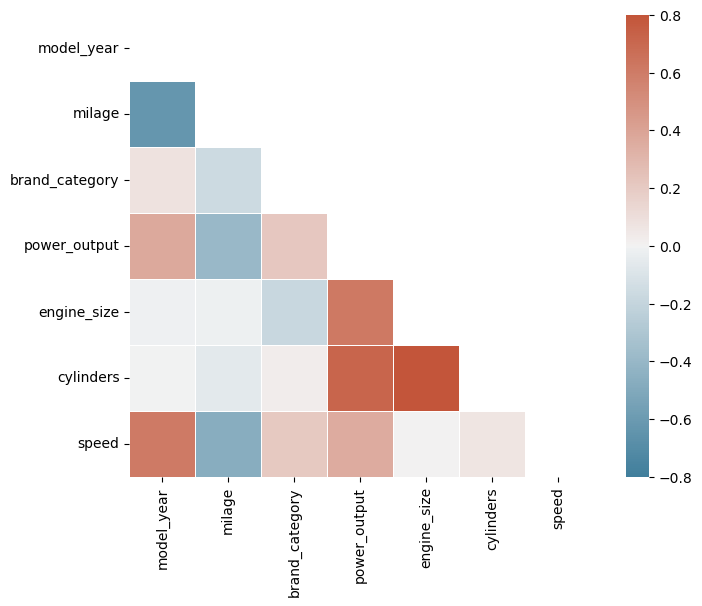

In [122]:
# Calculate correlation matrix 
# Check parameters: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html 
corr = df_train[numerical_features].corr() # method='pearson', 'kendall' , 'spearman'

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9,6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-0.8,vmax=0.8, square=True, linewidths=.5)
plt.show()

## Feature engineering



### Missing values to deal with:

speed: 46%

cylinders: 37%

power output: 7%

engine_size: 1%


Can we get this information based on the {brand , model, model_year, fuel_type, transmission_type , power_output}. 



model: too many unique values @ 1827


In [153]:
# impute the missing values:

# Combine train and test datasets to ensure consistency in imputation
#df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# Convert numeric columns to appropriate numeric types
columns_to_impute = ['speed', 'cylinders', 'power_output', 'engine_size']
#group_col = ['brand', 'model', 'transmission_type',  'model_year' ] #, 'fuel_type'

# Calculate the mean of columns_to_impute by grouping using group_col
#imputation_means = df_combined.groupby(group_col)[columns_to_impute].mean()

# Filling speed column with mean of Count column
#df_train.fillna(dataframe['speed'].mean(), inplace = True)

# Calculate mean for each column in df_train
impute_values = df_train[columns_to_impute].mean()


# Impute missing values in df_train
df_train_imputed  = df_train.fillna(impute_values, inplace=False)

# Impute missing values in df_test using the same impute_values
df_test_imputed = df_test.fillna(impute_values, inplace=False)



#df_train.groupby(group_col)['speed'].transform(lambda x: x.fillna(x.mean()))


In [154]:
# Plot numerical variables: imputed data

### Histogram plot function to display numerical features ###
def histogram_plot(var, dataframe1, dataframe2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True) # Share both axes for comparison
    sns.histplot(dataframe1[var].dropna(), ax=axes[0], kde=True, element="step", color="skyblue", bins=10)
    axes[0].set_title(f'Training Set - {var}')
    sns.histplot(dataframe2[var].dropna(), ax=axes[1], kde=True, element="step", color="orange", bins=10)
    axes[1].set_title(f'Testing Set - {var}')
    plt.tight_layout()
    plt.show()

def inter_num_plot(x):
    return histogram_plot(x, df_train_imputed, df_test_imputed)

### Multiple selection widgets for interactive plotting ###
widget_num_plot = widgets.Dropdown(
    options=numerical_features,
    description="Numerical Variable:", 
    style=style
)

interact(inter_num_plot, x=widget_num_plot)

interactive(children=(Dropdown(description='Numerical Variable:', options=('model_year', 'milage', 'brand_cate…

<function __main__.inter_num_plot(x)>

In [155]:

df = check_missing_values(df_test_imputed)
print(df.sort_values(by='Missing Values', ascending=False))

Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


In [156]:
df_train_imputed

,model_year,milage,fuel_type,accident,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,
27209,2013,70582,Gasoline,None reported,17900,2,other,200.0,2.0,4.0,6.000000,Manual,white,black
11434,2020,25000,Gasoline,None reported,35999,2,other,280.0,3.2,6.0,6.000000,Manual,white,grey
12270,2001,122000,Gasoline,None reported,7800,2,other,140.0,1.8,4.0,5.000000,Manual,blue,others
22959,2007,78980,Gasoline,At least 1 accident or damage reported,10600,2,other,272.0,3.5,6.0,6.000000,Manual,silver,brown
23411,2010,153843,Gasoline,At least 1 accident or damage reported,9450,2,other,150.0,2.0,4.0,5.000000,Manual,red,brown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51848,2018,110380,Gasoline,At least 1 accident or damage reported,31000,2,other,316.0,2.0,4.0,8.000000,Automatic,white,brown
52127,2018,60660,Gasoline,None reported,26000,2,other,316.0,2.0,4.0,8.000000,Automatic,white,black
53219,2017,66500,Gasoline,At least 1 accident or damage reported,22500,2,other,316.0,2.0,4.0,8.000000,Automatic,silver,grey


In [157]:
# Spliting the dataset.
Y = np.log(df_train_imputed[target_feature]) # transform the price to log(price)
X = df_train_imputed.drop(columns=[target_feature])

X_train, X_val,y_train,y_val = train_test_split(X, Y, test_size=0.20, random_state=5)

Cat: ['brand',
 'fuel_type',
 'accident',
 'brand_category',
 'transmission_type',
 'ext_color_basic',
 'int_color_basic']


 Num: ['model_year', 'milage', 'power_output', 'engine_size', 'cylinders']

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


one_hot_features = ['top_brand', 'fuel_type','transmission_type', 'ext_color_basic','int_color_basic' ,
                    'brand_category'] 
#label_encode_features = ['brand_category'] 
dummy_encode_features = ['accident'] 

# Function for dummy encoding
def dummy_encode(df):
    return pd.get_dummies(df, drop_first=True)

# Define the preprocessing for each column type
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('onehot', OneHotEncoder(), one_hot_features),
        ('dummy', FunctionTransformer(dummy_encode, validate=False), dummy_encode_features)
    ],
    remainder='passthrough'
)
'''
# Label encode separately as it needs to fit on the entire column
for col in label_encode_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
   # df_test_imputed[col] = le.transform(df_test_imputed[col])
'''

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f'R-squared: {r2}')
print(f'RMSE: {rmse}')

R-squared: 0.6819366056151217
RMSE: 0.42899778644708286


In [159]:
y_test_pred = pipeline.predict(df_test_imputed)
y_test_pred

y_hat_data = df_test_imputed.copy(deep = True)
y_hat_data['price_lm'] = np.exp( y_test_pred)

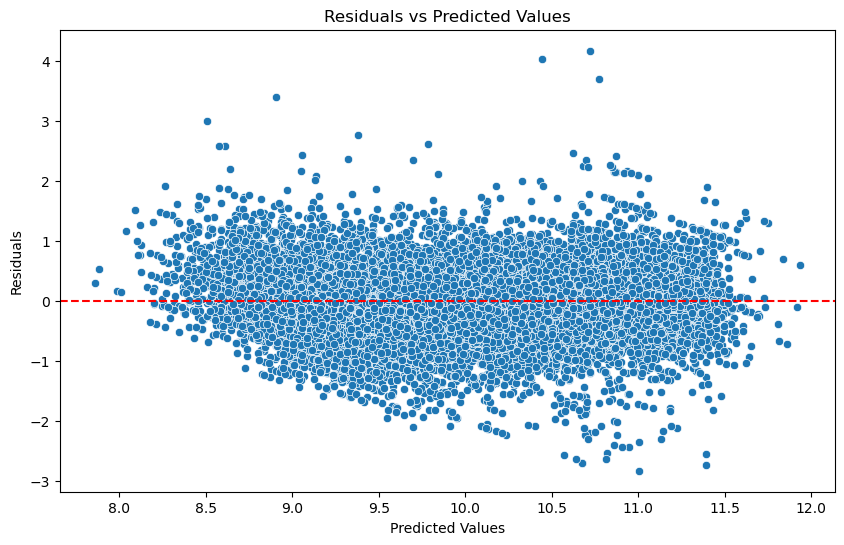

In [160]:
# residual analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the training set to analyze residuals
y_train_pred = pipeline.predict(X_train)

# Residuals
residuals = y_train - y_train_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred, y=residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(0, color='red', linestyle='--')
plt.show()


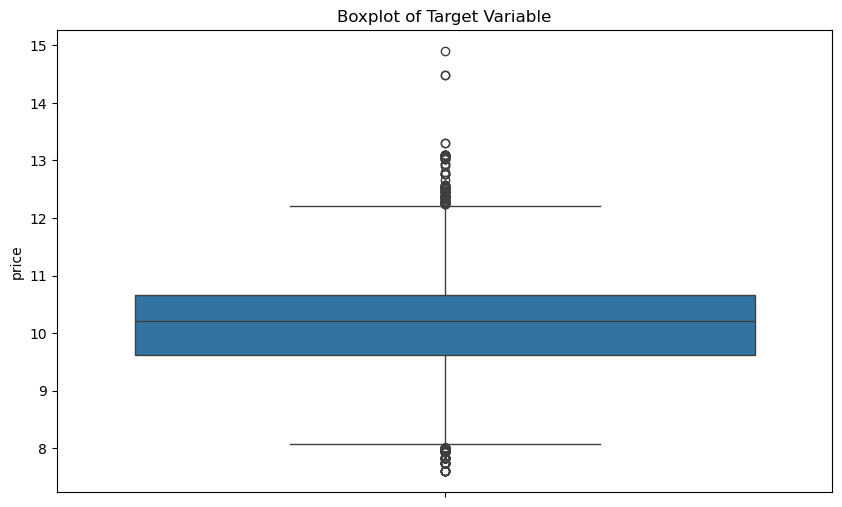

In [161]:
# outliers:
# Box plot to identify outliers in target variable
plt.figure(figsize=(10, 6))
sns.boxplot(y=y_train)
plt.title('Boxplot of Target Variable')
plt.show()


In [162]:
# model complexity

# Calculate training RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Print train and validation scores
print(f'Training RMSE: {train_rmse}')
print(f'Validation RMSE: {rmse}')
print(f'Training R-squared: {r2_score(y_train, y_train_pred)}')
print(f'Validation R-squared: {r2}')


Training RMSE: 0.4289302555248152
Validation RMSE: 0.42899778644708286
Training R-squared: 0.6856303444671104
Validation R-squared: 0.6819366056151217


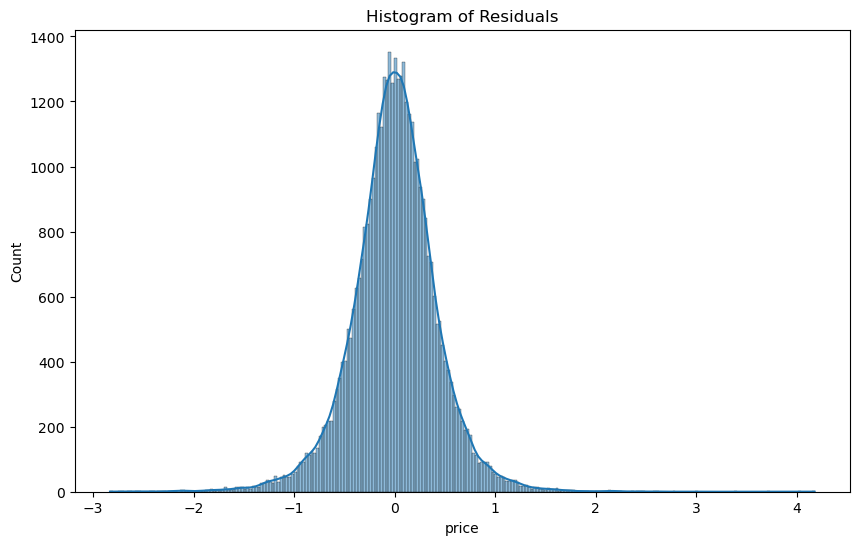

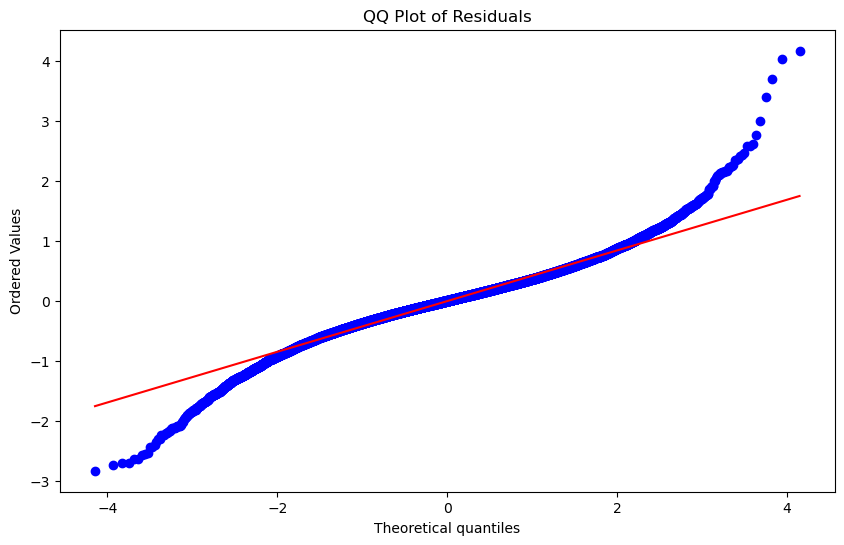

In [163]:
# Check normality of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# QQ plot
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()


In [171]:
# influencial data points

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Preprocess the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Convert the preprocessed data to a DataFrame and add a constant
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed)
X_train_preprocessed_df = sm.add_constant(X_train_preprocessed_df)

# Fit the OLS model
model = sm.OLS(y_train, X_train_preprocessed_df).fit()

# Get influence measures
influence = model.get_influence()

# Leverage values (Hat values)
leverage = influence.hat_matrix_diag

# Cook's Distance
cooks_d = influence.cooks_distance[0]

# Influence Summary
summary_frame = influence.summary_frame()

# Set thresholds for identifying influential points
leverage_threshold = 2 * (X_train_preprocessed_df.shape[1]) / len(X_train_preprocessed_df)
cooks_threshold = 4 / len(X_train_preprocessed_df)

# Get indices of influential points
influential_points = np.where((leverage > leverage_threshold) | (cooks_d > cooks_threshold))[0]

# Investigate the influential points in the dataframe
influential_data = X_train.iloc[influential_points]

# Print influential data points
print(influential_data)



ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [170]:
X_train_preprocessed_df

,const,0
0,1.0,"(0, 0)\t-2.5069308392737857\n (0, 1)\t0.5718485849634386\n (0, 2)\t-1.0395067708611039\n (0, 3)\t-0.20476742098071848\n (0, 4)\t2.3114038718941923\n (0, 5)\t2.422443928536831\n (0, 6)\t-1.5080822588984142\n (0, 11)\t1.0\n (0, 23)\t1.0\n (0, 28)\t1.0\n (0, 32)\t1.0\n (0, 40)\t1.0\n (0, 48)\t1.0\n (0, 51)\t1.0"
1,1.0,"(0, 0)\t0.8974313388648463\n (0, 1)\t-1.0116226880428658\n (0, 2)\t1.0788731981403943\n (0, 3)\t1.593993013819842\n (0, 4)\t0.20966643374274607\n (0, 5)\t1.1193164482981932\n (0, 6)\t1.4646196478186746\n (0, 16)\t1.0\n (0, 23)\t1.0\n (0, 28)\t1.0\n (0, 35)\t1.0\n (0, 40)\t1.0\n (0, 50)\t1.0\n (0, 51)\t1.0"
2,1.0,"(0, 0)\t0.7182543821207078\n (0, 1)\t-0.8859176236836138\n (0, 2)\t0.019683213639645147\n (0, 3)\t-0.7919275629104351\n (0, 4)\t-1.2915745935082872\n (0, 5)\t-1.4869385121790821\n (0, 6)\t0.7446684047856297\n (0, 14)\t1.0\n (0, 23)\t1.0\n (0, 28)\t1.0\n (0, 37)\t1.0\n (0, 42)\t1.0\n (0, 49)\t1.0\n (0, 51)\t1.0"
3,1.0,"(0, 0)\t0.8974313388648463\n (0, 1)\t-0.9460132918768188\n (0, 2)\t-1.0395067708611039\n (0, 3)\t-1.6493677701728784\n (0, 4)\t-1.8170089530461484\n (0, 5)\t-2.1385022522984007\n (0, 6)\t1.4646196478186746\n (0, 10)\t1.0\n (0, 23)\t1.0\n (0, 28)\t1.0\n (0, 32)\t1.0\n (0, 40)\t1.0\n (0, 48)\t1.0"
4,1.0,"(0, 0)\t-0.17763040159998486\n (0, 1)\t0.9090190005688794\n (0, 2)\t1.0788731981403943\n (0, 3)\t-0.2979674435092449\n (0, 4)\t-0.5409540798827706\n (0, 5)\t-0.18381103194044449\n (0, 6)\t0.6602048511337081\n (0, 8)\t1.0\n (0, 23)\t1.0\n (0, 27)\t1.0\n (0, 32)\t1.0\n (0, 40)\t1.0\n (0, 50)\t1.0\n (0, 51)\t1.0"
...,...,...
40892,1.0,"(0, 0)\t0.0015465551441536697\n (0, 1)\t-0.06877520468689871\n (0, 2)\t1.0788731981403943\n (0, 3)\t1.0534328831543884\n (0, 4)\t0.509914639192953\n (0, 5)\t1.1193164482981932\n (0, 6)\t0.7446684047856297\n (0, 8)\t1.0\n (0, 23)\t1.0\n (0, 28)\t1.0\n (0, 32)\t1.0\n (0, 40)\t1.0\n (0, 50)\t1.0"
40893,1.0,"(0, 0)\t-2.327753882529647\n (0, 1)\t0.36756298021425987\n (0, 2)\t0.019683213639645147\n (0, 3)\t-0.8664875809332563\n (0, 4)\t0.6600387419180558\n (0, 5)\t1.1193164482981932\n (0, 6)\t-2.1351365673465503\n (0, 20)\t1.0\n (0, 23)\t1.0\n (0, 28)\t1.0\n (0, 39)\t1.0\n (0, 43)\t1.0\n (0, 49)\t1.0\n (0, 51)\t1.0"
40894,1.0,"(0, 0)\t0.7182543821207078\n (0, 1)\t-0.41187585289622336\n (0, 2)\t-1.0395067708611039\n (0, 3)\t-0.06496738718792883\n (0, 4)\t-0.7661402339704253\n (0, 5)\t-0.18381103194044449\n (0, 6)\t-0.6952340812804603\n (0, 11)\t1.0\n (0, 23)\t1.0\n (0, 28)\t1.0\n (0, 35)\t1.0\n (0, 40)\t1.0\n (0, 48)\t1.0\n (0, 51)\t1.0"
40895,1.0,"(0, 0)\t1.0766082956089849\n (0, 1)\t-0.5784975388668885\n (0, 2)\t-1.0395067708611039\n (0, 3)\t0.40103272545470336\n (0, 4)\t-0.1656438230700122\n (0, 5)\t-0.18381103194044449\n (0, 6)\t1.842899114497054\n (0, 11)\t1.0\n (0, 23)\t1.0\n (0, 27)\t1.0\n (0, 32)\t1.0\n (0, 40)\t1.0\n (0, 48)\t1.0\n (0, 51)\t1.0"


In [164]:
# Train and save multiple models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import joblib


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Gradient Boost Regressor": GradientBoostingRegressor(random_state=42, learning_rate=0.05, loss="squared_error")
    #"SVR": SVR()
}

best_model = None
best_score = float('-inf')
best_model_name = ""

for name, model in models.items():
    model.fit(preprocessor.transform(X_train), y_train)
    y_pred = model.predict(preprocessor.transform(X_val))
    r2 = r2_score(y_val, y_pred)
    print(f"{name} R^2 score: {r2}")
    if r2 > best_score:
        best_score = r2
        best_model = model
        best_model_name = name

# Save the best model
joblib.dump(best_model, 'best_model.pkl')

print(f"Best model: {best_model_name} with R^2 score: {best_score}")


Linear Regression R^2 score: 0.6819366056151217
Random Forest R^2 score: 0.7105957829701527
XGBoost R^2 score: 0.7202677736341507
Gradient Boost Regressor R^2 score: 0.7096942519998448
Best model: XGBoost with R^2 score: 0.7202677736341507


## Hyperparameter Tuning

In [140]:
from sklearn.model_selection import RandomizedSearchCV

# Define the models and hyperparameter grids
models = {
    "Linear Regression": (LinearRegression(), {}),
    "Random Forest": (RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30, 40, 50]
    }),
    "XGBoost": (XGBRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.1, 0.2, 0.3]
    })
    # SVR is too heavy for tuning...
}

best_model = None
best_score = float('-inf')
best_model_name = ""

for name, (model, param_grid) in models.items():
    if param_grid:
        search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, scoring='r2', random_state=42, n_jobs=-1)
        search.fit(preprocessor.transform(X_train), y_train)
        best_model_for_name = search.best_estimator_
    else:
        best_model_for_name = model
        best_model_for_name.fit(preprocessor.transform(X_train), y_train)
    
    y_pred = best_model_for_name.predict(preprocessor.transform(X_val))
    r2 = r2_score(y_val, y_pred)
    print(f"{name} R^2 score: {r2}")
    if r2 > best_score:
        best_score = r2
        best_model = best_model_for_name
        best_model_name = name

# Save the best model and its name
joblib.dump(best_model, 'hypertuned_best_model.pkl')

print(f"Best model: {best_model_name} with R^2 score: {best_score}")



Linear Regression R^2 score: 0.6091838997337604
Random Forest R^2 score: 0.646582602587013
XGBoost R^2 score: 0.6481680302276254
Best model: XGBoost with R^2 score: 0.6481680302276254


In [165]:
# Load the test data, make predictions, and save the results
df_test_imputed_transformed = preprocessor.transform(df_test_imputed)
predictions = best_model.predict(df_test_imputed_transformed)
results = pd.DataFrame({
    'price': predictions
})

# Save results to a CSV file
#results.to_csv('../datasets/predictions.csv', index=False)
#print("Predictions saved to predictions.csv")

In [166]:
results
y_hat_data['price_xgb'] = np.exp(predictions)
#y_hat_data
#df_train_imputed[df_train_imputed['brand']=='Saab']

In [167]:
# add 'ensemble'
y_hat_data['price_mix'] = (y_hat_data['price_lm'] + y_hat_data['price_xgb'])/2
y_hat_data

,model_year,milage,fuel_type,accident,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic,price_lm,price_xgb,price_mix
id,,,,,,,,,,,,,,,,
54273,2014,73000,Gasoline,None reported,3,Mercedes-Benz,302.0,3.5,6.0,7.173529,Automatic,white,brown,23503.142645,19982.492188,21742.817416
54274,2015,128032,Gasoline,None reported,3,Lexus,275.0,3.5,6.0,8.000000,Automatic,silver,black,18786.859870,18040.835938,18413.847904
54275,2015,51983,Gasoline,None reported,3,Mercedes-Benz,241.0,2.0,4.0,7.000000,Automatic,blue,white,25727.268485,26452.992188,26090.130336
54276,2018,29500,Gasoline,At least 1 accident or damage reported,2,Land,518.0,5.0,8.0,7.974359,AM,white,white,54653.765312,50334.046875,52493.906094
54277,2020,90000,Gasoline,At least 1 accident or damage reported,3,BMW,335.0,3.0,6.0,8.000000,Automatic,white,black,28153.846295,33675.062500,30914.454397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90451,2019,4500,Gasoline,None reported,1,GMC,420.0,6.2,8.0,10.000000,Automatic,grey,black,57132.610962,52227.937500,54680.274231
90452,2004,185000,Gasoline,At least 1 accident or damage reported,1,Chevrolet,295.0,5.3,8.0,4.000000,Automatic,red,grey,6588.995376,7729.141602,7159.068489
90453,2011,116000,Gasoline,None reported,1,Toyota,132.0,1.8,4.0,5.000000,Manual,brown,grey,11899.400192,9799.973633,10849.686913


In [168]:
# saving the predictions to csv
y_hat_data['price_lm'].to_csv('../datasets/predictions_lm_3.csv')
y_hat_data['price_xgb'].to_csv('../datasets/predictions_xgb_3.csv')
y_hat_data['price_mix'].to_csv('../datasets/predictions_mix_3.csv')
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


Sources:

https://www.kaggle.com/competitions/kagglex-cohort4/overview

https://www.kaggle.com/code/saadatkhalid/laptop-price-prediction-eda-model-app

